# Bigram Language model




In [15]:
# Variables 
SEEDS = 2147483647

## Data loading and pre-processing

In [16]:
words = open('name.txt', 'r').read().splitlines()

In [17]:
min(len(w) for w in words)

2

In [18]:
max(len(w) for w in words)

15

In [19]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

> Note: here each letter carries a lot of statiscal info regarding the placement of the characters like "Emma" tells us that character E is followed by a and character s is end of the word 

In [20]:
b = {} # Dict to contain the count of each biagram

for w in words:
    # Adding SOS and EOS 
    chs = ['<S>'] + list(w) + ['<E>']
    # Spliting the characters in pairs
    for ch1, ch2 in zip(chs, chs[1:]):
        biagram = (ch1, ch2)
        b[biagram] = b.get(biagram, 0) + 1


In [21]:
sorted(b.items(), key= lambda ks: -ks[1])[:10] # the top 10 biagram 

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

## Converting the counts of biagram into a 2-D array 

In [22]:
import torch 

In [23]:
N = torch.zeros((27, 27), dtype=torch.int32)


In [24]:
chars = sorted(set(''.join(words)))

# Dict to map character to number 
stoi = {s: i+1 for i, s in enumerate(chars)} 
stoi['.'] = 0 # SOS and EOS can be represented by '.'

# Dict to map numbers to characters
itos = {s:i for i, s in stoi.items()}

In [25]:
for w in words:
    # Adding SOS and EOS to each words
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        # getting the index using the mapping Dict 
        idx1, idx2 = stoi[ch1], stoi[ch2]
        # Updating the count for specific index 
        N[idx1, idx2] += 1


## Plotting the N(Biagram Count 2-D array)

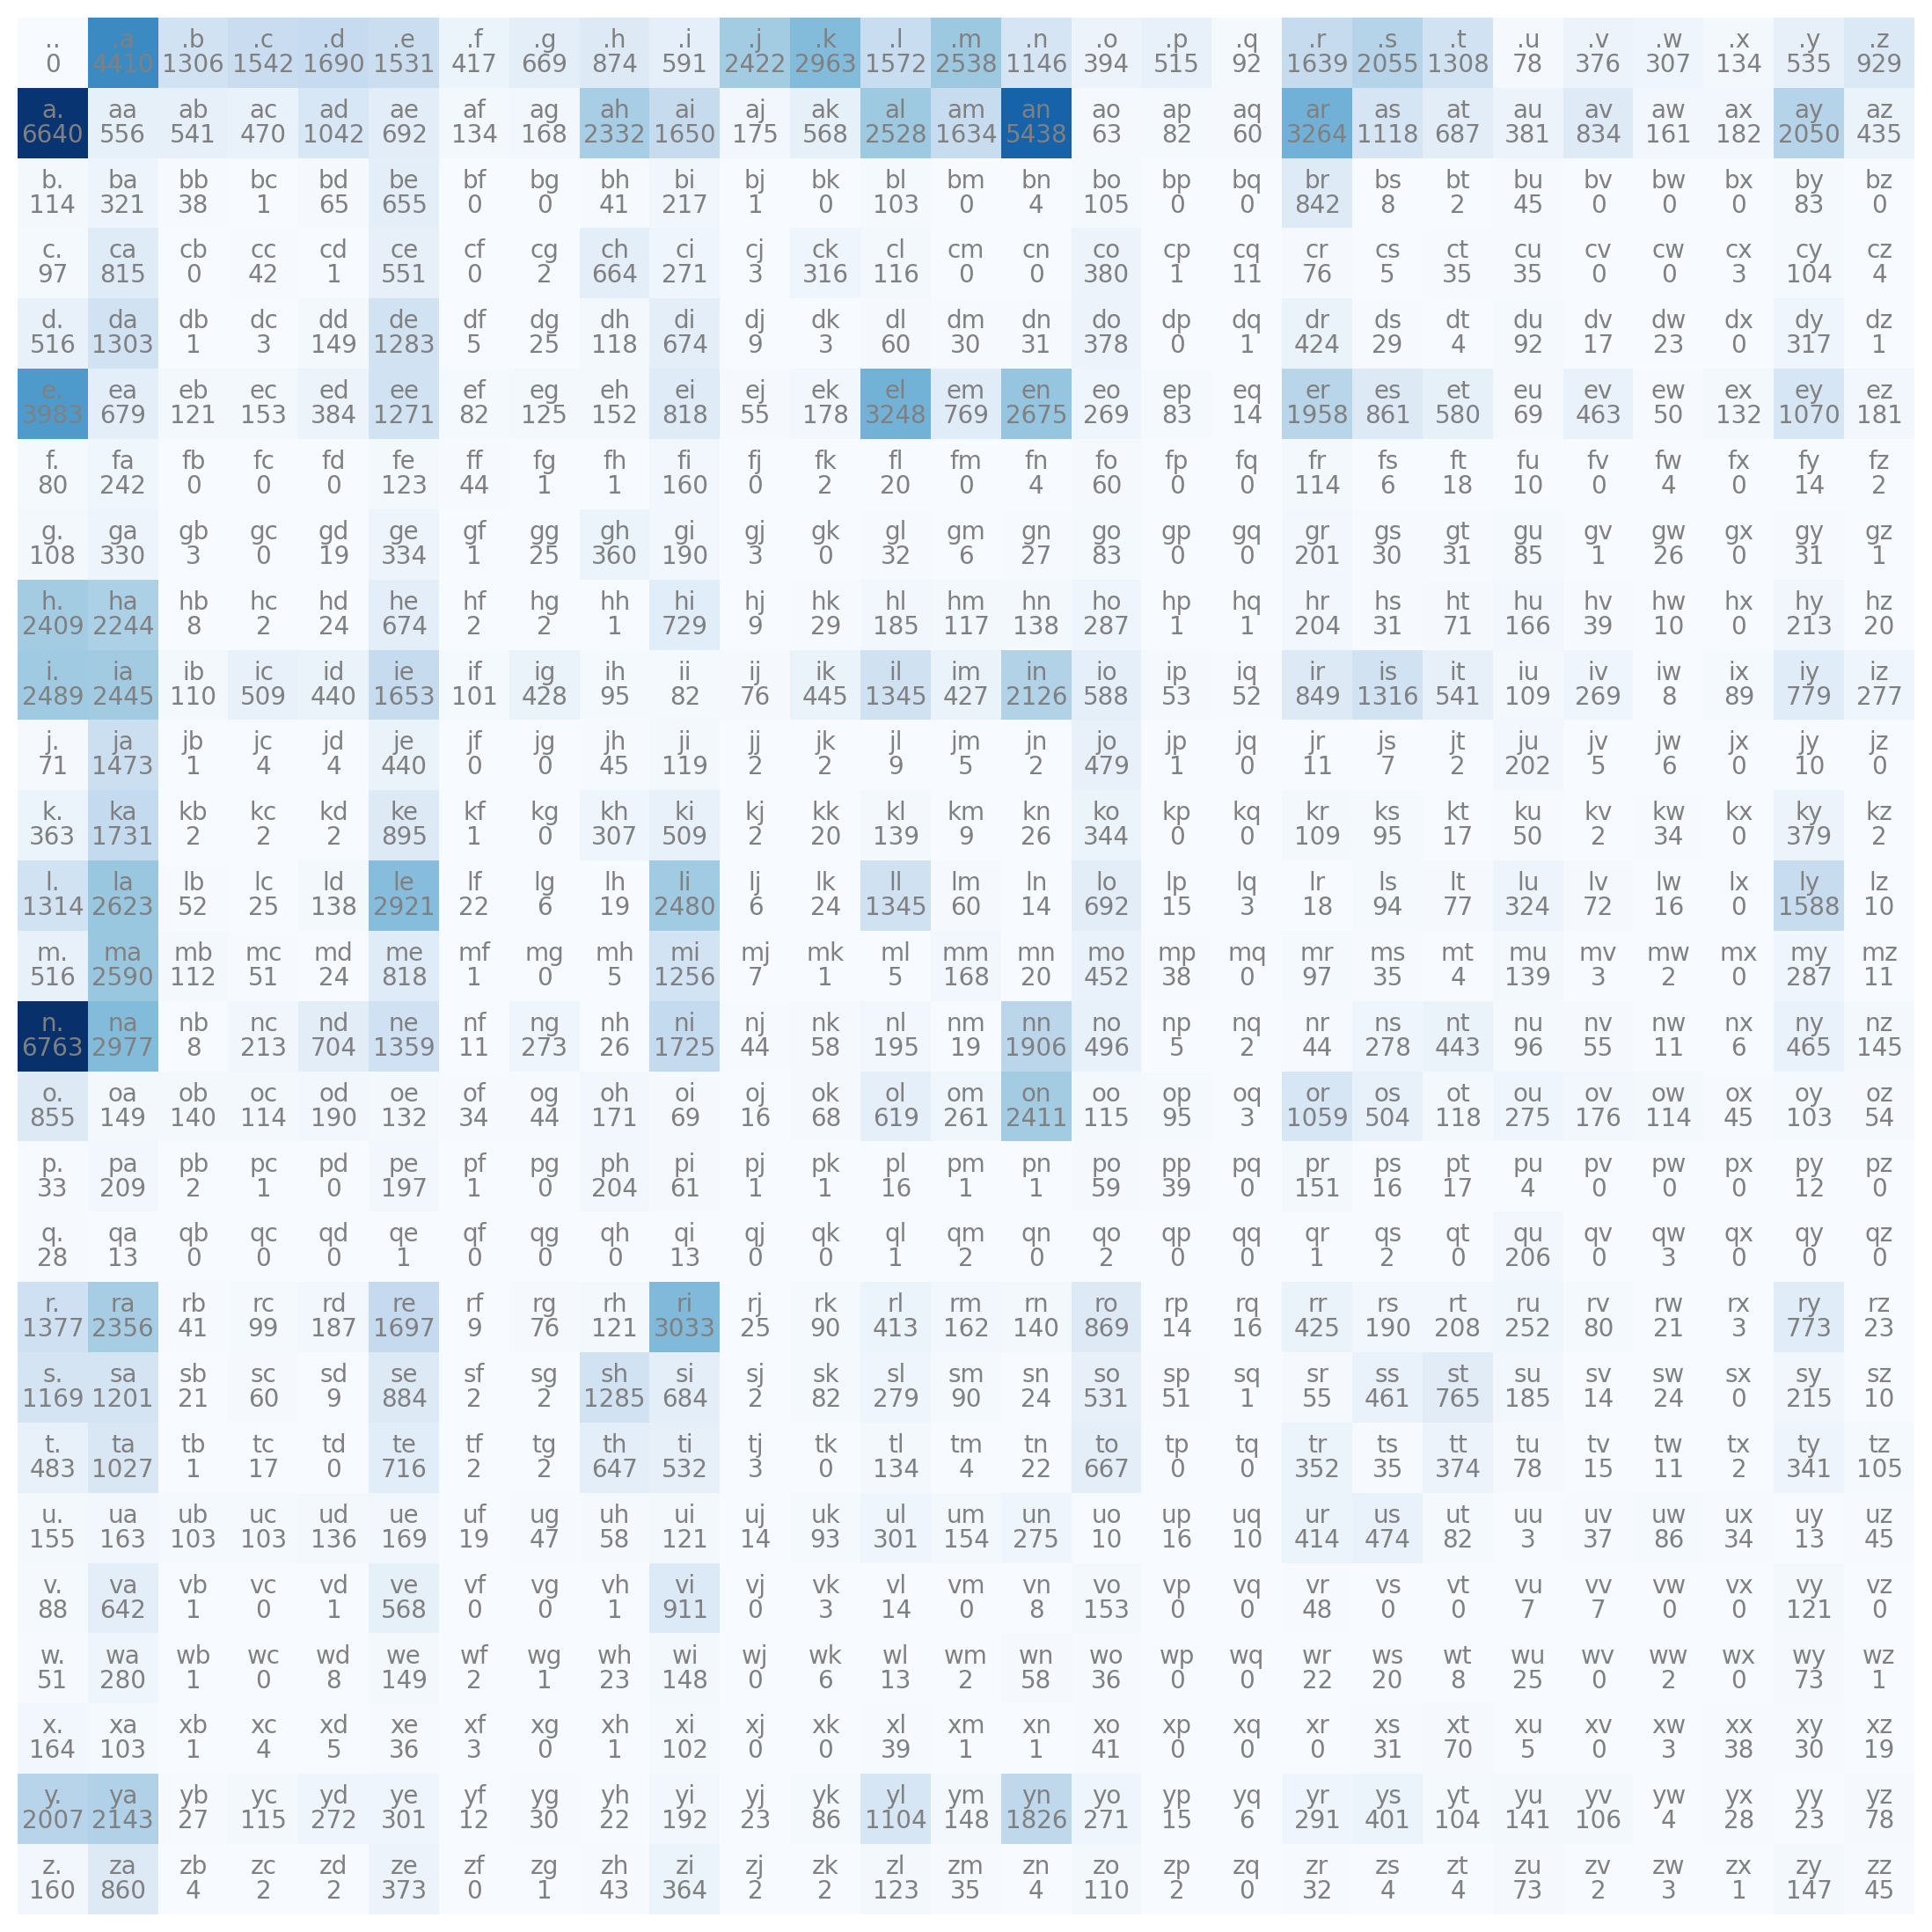

In [26]:
import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.figure(figsize=(16,14))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [27]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [28]:
# Getting the probabilities 
p = N[0].float()
p = p/p.sum()
p # this has probability for any single character to be first

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

So now we have a nice proper probability distribution which sums to 1. now we can sample from this distribution 

In [29]:
g = torch.Generator().manual_seed(SEEDS)
# p  = torch.rand(3, generator=g)
# p = p / p.sum()

In [30]:
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix, itos[ix] # this means the first charcter is "t"


(10, 'j')

In [31]:
g = torch.Generator().manual_seed(SEEDS)

for i in range(10):
    out = []
    # we will start with the first row as it contains data for staring characters
    ix = 0 
    while True: 
        # Getting the counts and normalization/getting the probabilites
        p = N[ix].float()
        p = p / p.sum() 

        # sampling 
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        if ix == 0: # that means we have gotten the end of the word
            break
    print(''.join(out))

# Bigram language model is terible most of these words don't have any meaning like [a., p.,ksahnaauranilevias.] even if we do it multiple time its the same 
# This is beacuse it doesn't know much of the info like all it konws it p is previous character and now it tries to figure out how likely p is last character 
# hence p. 

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [32]:
# Optimization 
# 27, 27 - axis 0 , axis 1 
# what we want is to sum along the rows that is axis 1 
# 27, 1
P = N.float()
# P = P / P.sum(axis=1, keepdims=True) # here broadcasting is getting applied 
P /= P.sum(axis=1, keepdim=True) # this is going to be faster compared to above as its implcae 
P[0]


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


Two tensors are “broadcastable” if the following rules hold:
* Each tensor has at least one dimension.
* When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [33]:
g = torch.Generator().manual_seed(SEEDS)

for i in range(10):
    out = []
    ix = 0 
    while True: 
        p = P[ix] 
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0: 
            break
    print(''.join(out))


junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


**Same results as above when we were fetching count and calculating the probability again and again**

In [34]:
# Now to summarize the probabilities into a single number that measure the  quality of this model
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2 in zip(chs, chs[1:]):
        ix1 , ix2 = stoi[chs1], stoi[chs2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        print(f"{chs1}{chs2}: {prob=:.4f} {logprob=:.4f}")

.e: prob=0.0478 logprob=-3.0408
em: prob=0.0377 logprob=-3.2793
mm: prob=0.0253 logprob=-3.6772
ma: prob=0.3899 logprob=-0.9418
a.: prob=0.1960 logprob=-1.6299
.o: prob=0.0123 logprob=-4.3982
ol: prob=0.0780 logprob=-2.5508
li: prob=0.1777 logprob=-1.7278
iv: prob=0.0152 logprob=-4.1867
vi: prob=0.3541 logprob=-1.0383
ia: prob=0.1381 logprob=-1.9796
a.: prob=0.1960 logprob=-1.6299
.a: prob=0.1377 logprob=-1.9829
av: prob=0.0246 logprob=-3.7045
va: prob=0.2495 logprob=-1.3882
a.: prob=0.1960 logprob=-1.6299


In [35]:
# maximum likelihood estimation (MLE) is a method of estimating the parameters of an assumed probability 
# distribution, given some observed data. This is achieved by maximizing a likelihood function so that, 
# under the assumed statistical model, the observed data is most probable.

# But we can see that if we multiply these probabilities it will become even more less 
# so what we are going to use is log of probabilities as log is monotoinic(varying in such a way that it either never decreases or never increases.)

# log(1) = 0 and log of anything less than 1 is negative


## Goal: 

* Maximize likehood of the data w.r.t model parameters (statistical modeling)
* Equivalent to maximizing the log likehood as log in monotoinc
* Equivalent to minimizing the negative log likehood 
* Equivalent to minimizing the average negative log likehood

`log(a*b*c) = log(a) + log(b) + log(c)`

In [36]:
log_likehood = 0.0 
n = 0 

for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2 in zip(chs, chs[1:]):
        ix1 , ix2 = stoi[chs1], stoi[chs2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likehood += torch.log(prob)
        n += 1 
        print(f"{chs1}{chs2}: {prob:.4f} {logprob:.4f}")

print(f'{log_likehood=}')
nll = -log_likehood
print(f'{nll=}')
print(f'{nll/n}')

# For us the parameters are the probabilites - the count which we saved in N 
# In neural network these counts will be calculated by the network 

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likehood=tensor(-38.7856)
nll=tensor(38.7856)
2.424102306365967


In [37]:
# for the entire training set 

log_likehood = 0.0 
n = 0 

for w in words:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2 in zip(chs, chs[1:]):
        ix1 , ix2 = stoi[chs1], stoi[chs2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likehood += torch.log(prob)
        n += 1 
        

print(f'{log_likehood=}')
nll = -log_likehood
print(f'{nll=}')
print(f'{nll/n}')


log_likehood=tensor(-559891.7500)
nll=tensor(559891.7500)
2.454094171524048


In [38]:
# Evalutating for any word

log_likehood = 0.0 
n = 0 

for w in ['shushankx']:
    chs = ['.'] + list(w) + ['.']
    for chs1, chs2 in zip(chs, chs[1:]):
        ix1 , ix2 = stoi[chs1], stoi[chs2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likehood += torch.log(prob)
        n += 1 
        print(f"{chs1}{chs2}: {prob:.4f} {logprob:.4f}")

print(f'{log_likehood=}')
nll = -log_likehood
print(f'{nll=}')
print(f'{nll/n}')

# 2.620375156402588 - which means that shushank is quite a proable word 
# but if we check for 'shushankx' we will get infinity as in our dataset we have kx prob = 0 
# to fix this we can just add N +1 when we are calculating the probabilities for the dataset this helps in smothing out the model
# which change the likehood to 3.0959503650665283 

.s: 0.0642 -2.7465
sh: 0.1585 -1.8418
hu: 0.0218 -3.8260
us: 0.1512 -1.8892
sh: 0.1585 -1.8418
ha: 0.2946 -1.2220
an: 0.1605 -1.8296
nk: 0.0032 -5.7557
kx: 0.0000 -inf
x.: 0.2353 -1.4469
log_likehood=tensor(-inf)
nll=tensor(inf)
inf


In [39]:
P = (N +1).float()
P /= P.sum(axis=1, keepdim = True)
P[0]

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])

## Neural Network approach to bigram

In [40]:
# creating the dataset 
xs , ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1] , stoi[ch2]
        xs.append(ix1), ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [41]:
xs , ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [42]:
# how are we going to feed this data to neural net 
# we cannot feed the index so how 
# for each example lets have a vector in which a certain index is 1 rest everything is off 
# so which says that our neural net will take 27 inputs 

import torch.nn.functional as F

In [43]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc 

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [44]:
xenc.shape

torch.Size([5, 27])

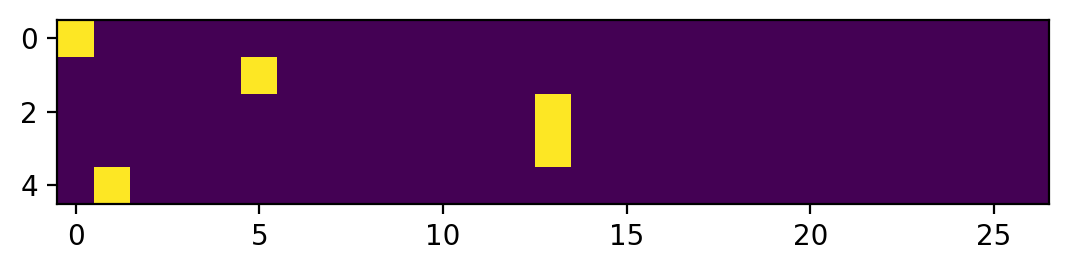

In [45]:
plt.imshow(xenc) 
plt.show()

In [46]:
xenc.dtype

torch.float32

In [47]:
# So what we do in a neural netwrok is inputs @ weights + bias 
# so here our inputs will be one hot encoded and weights we will randomly intiallize 
# we will use torch.randn which gives random number from a  normal distribution
g = torch.Generator().manual_seed(SEEDS)
W = torch.randn((27,27), generator=g) # this (27, 1) weight tensor will look at all the rows in xenc 
xenc @ W

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

In [48]:
# the reason why we get a 5 ,1 tensor back is due to matrix multiplication plus we can also deduce only 1 index is turned on 
# in our xenc and rest are set of 0 so for 5 rows are getting the wegiths back of that specific index 
print(W[0,0])

tensor(1.5674)


In [51]:
# so now we have 27 inputs and 27 neurons so that why the weights are intiallized as (27, 27) as each neuron will get 27 inputs 
# the result of this we are interpreting them as log count and then we will take the exponent of them 
# as e^x has a range of (y E R,y>0)
(xenc @ W).exp()

tensor([[ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
          1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
          4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
          0.9317, 12.1434, 11.5281],
        [ 1.6038,  4.4060,  1.3737,  2.8830, 11.0032,  1.5972,  0.5187,  1.8527,
          0.5369,  1.6654,  3.8818,  1.2642,  0.6339,  0.9987,  0.5995,  1.7432,
          1.6073,  0.2499,  5.0680,  1.1876,  2.6871,  1.6596,  2.7728,  0.1486,
          0.6521,  0.1193,  2.6128],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373,
          2.2763,  0.4719,  2.5289,  0.2265,  0.8082,  0.3054,  0.5164,  0.7918,
          4.6866,  1.8232,  0.4921],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373

In [52]:
logits = xenc @ W # log-count : but why are we considering them log counts 
counts = logits.exp() # equivalent of N matrix 
probs = counts / counts.sum(1, keepdim=True)
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [53]:
probs[0].sum()

tensor(1.0000)

## ---------------------------------------------!! Summary !!-----------------------------------------------

In [54]:
# creating the dataset and one hot encoding them 
import torch.nn.functional as F

xs , ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1, idx2 = stoi[ch1], stoi[ch2]
        xs.append(idx1), ys.append(idx2)

# converting the dataset to tensor 
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# one-hot encoding the xs 
xenc = F.one_hot(xs, num_classes=27).float()

# Creating the Weights Tensor (27, 27) 
g = torch.Generator().manual_seed(SEEDS)

W = torch.randn(size=(27, 27), generator=g)

In [55]:
logits = xenc @ W # log-count : but why are we considering them log counts 
counts = logits.exp() # equivalent of N matrix 
probs = counts / counts.sum(1, keepdim=True) # normalizing to get the probabilities 
# the last 2 lines are softmax activation 

In [57]:
probs.shape

torch.Size([5, 27])

In [58]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.

## -------------------------------------------!! Optimization yay !!-------------------------------------------

In [74]:
xs 

tensor([ 0,  5, 13, 13,  1])

In [75]:
ys 

tensor([ 5, 13, 13,  1,  0])

In [76]:
g = torch.Generator().manual_seed(SEEDS)
W = torch.randn(size=(27, 27), generator=g, requires_grad=True)


In [81]:
# Forward pass 
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W 
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [82]:
loss.item()

3.5693678855895996

In [79]:
# backward pass 
W.grad = None
loss.backward()

In [80]:
W.data += -1 * W.grad

# Complete Model

In [89]:
# imports 
import torch 
import torch.nn.functional as F

# Setting the SEED
SEED = 2147483647


# Read the dataset
words = open('name.txt', 'r').read().splitlines()


#Creating a look up dictonary
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i ,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for i,s in stoi.items()}


# creating the dataset for training
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print(f"Number of elements: {num}")


# weights tensor (27, 27)
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)


Number of elements: 228146


In [92]:
# Gradient descent
for k in range(1):
    # one hot encoding 
    xenc = F.one_hot(xs, num_classes= 27).float()


    # forward pass
    logits = xenc @ W 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim= True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(f"Loss: {loss}")


    # backward pass 
    W.grad = None
    loss.backward()

    # Update
    W.data += -50 * W.grad


Loss: 3.161090850830078
